In [45]:
import numpy as np
import astropy.units as u
import matplotlib.pylab as plt
import matplotlib.cm as cm
from astropy.time import Time
import astropy.units as u
from pulsar.predictor import Polyco
from scipy.stats import binned_statistic
import glob
%matplotlib inline
pfont = {'fontname':'Helvetica'}
figures = 1
figdir = '/home/ramain/packages/b1957GiantPulses'

In [6]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine / abs(p1fine)) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_rts(p1, p2, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_ts = dechannelize(p12_phased)
    return p12_ts

def wfilter(p2, p1, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)

    # Hardcoded, which is unfortunate
    #SN = (abs(p1fine[32])- abs(p1fine[:20]).mean(axis=0)) / abs(p1fine)[:20].std(axis=0)
    SN = abs(p1fine[0])
    SN[SN < 0.01] = 0.01
    H = p1fine / abs(p1fine)
    G = (1 / H) * ( abs(H)**2.0 / (abs(H)**2.0 + (1/SN[np.newaxis,:])) )
    Y = p2fine

    x = rechannelize(G * Y, cchan)
    return x

def power(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    power = (abs(dR)**2 + abs(dL)**2)
    return power

def powerchan(dchan):
    R = np.array([8,0,10,2,12,4,14,6])
    L = np.array([9,1,11,2,13,5,15,7])
    dR = dchan[...,R]
    dL = dchan[...,L]
    power = abs(dR)**2.0 + abs(dL)**2.0
    return power

def normpower(pulse):
    p1temp = rechannelize(pulse, 256)
    power1 = abs(p1temp)**2.0
    power1 = power1[16] - power1[2:12].mean(axis=0)
    power1 = power1[32:-32]
    power1 = (power1 - power1.mean(axis=0)) / power1.std(axis=0)
    return power1

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def pad(ts,nzeros):
    ts = np.concatenate((ts,0*ts[:nzeros]), axis=0)
    return ts
    
def rechanIm(pulse, nchan):
    pulse = np.fft.ifft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:  
        pol = pulse.shape[-1]
    else:
        pol = 1
    
    pulse = pulse.reshape(-1,pol)
    zero_padding = nchan - pulse.shape[0] % nchan
    
    print(pulse.shape, nchan, zero_padding)
    
    if zero_padding > 0:
        pulse = pad(pulse,zero_padding)

    pulse = pulse.reshape(-1, nchan, pol)
    pulse = np.fft.fft(pulse, axis=1)
    
    return pulse

In [7]:
"""
Load all b1957 Pulses
"""

b1957GPs = np.loadtxt('/home/ramain/packages/scint_analysis/b1957_GPs/gp_RCP_SN12clean.txt', dtype='string')
                      
bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

"""
Take only first two days for simpicity (i.e. ignore weirdness at eclipse)
"""

bdT = bT.unix - np.roll(bT.unix, 1)
bsort = np.argsort(bdT)
#bdT[bsort]

Mean pulse flux = 0.0370254054243 Jy


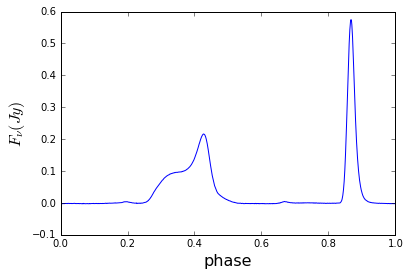

In [8]:
"""
Figure 1A - Nikhil's pulse lists
"""
GPSN, GPphase = np.load('giant_pulse.npy')
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

print("Mean pulse flux = %s Jy" % (mean_value))

plt.plot(np.arange(1000)/1000., meanprof_Jy)
plt.xlabel('phase', fontsize=16)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=16)

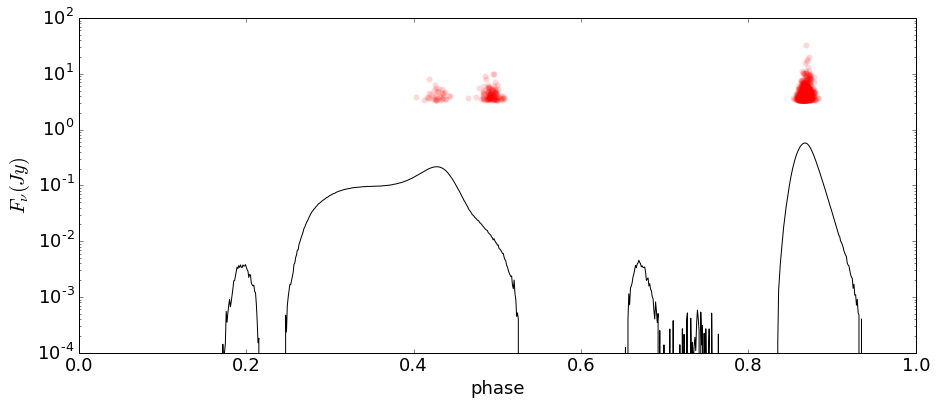

In [9]:
sig_conversion = 0.0283112
GPJy = GPSN * sig_conversion * 12.

coarse_bins = np.linspace(0,1,101)[:-1]
GPhist = binned_statistic(GPphase, GPJy, statistic='sum', bins = coarse_bins)[0]
GPhist /= 16200000 # (number of pulses in 3 days)

plt.figure(figsize=(15, 6))

plt.plot(np.arange(1000)/1000., meanprof_Jy, 'k')
plt.plot(GPphase, GPJy, 'ro', alpha=0.15, markeredgecolor = 'none')
#plt.plot(coarse_bins[1:]+0.005, GPhist, 'grey', drawstyle='steps')

plt.yscale('log')
plt.ylim(1e-4, 1e2)

plt.xlabel('phase', fontsize=18)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/fig1a.pdf', dpi=500)

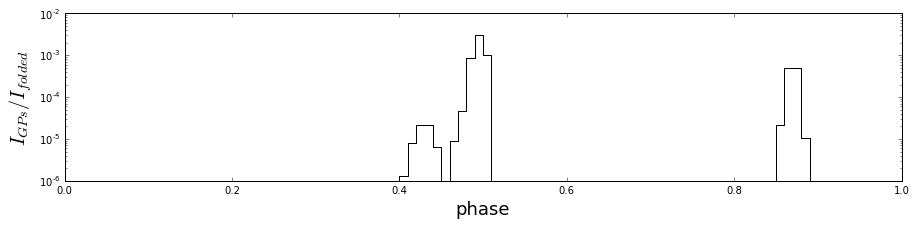

In [10]:
""" Fig 1 B - show ratio of power in GPs """

prof_binned = meanprof_Jy.reshape(-1, 10).mean(-1)


plt.figure(figsize=(15, 3))
plt.plot(coarse_bins[1:], GPhist / prof_binned[1:], 'k', drawstyle='steps')

plt.yscale('log')
plt.xlabel('phase', fontsize=18)
plt.ylabel(r'$I_{GPs} / I_{folded}$', fontsize=20)

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/fig1b.pdf', dpi=500)

ts = -12.2088526955
(160,)


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


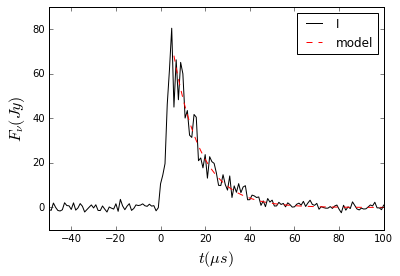

In [11]:
"""
Profile of Brightest Pulse

Calculation of scattering time from exponential fit
"""
nyq_pad = np.zeros((100,1))

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))

GPR = np.concatenate((GPR,nyq_pad), axis=-1)
GPL = np.concatenate((GPL,nyq_pad), axis=-1)

GPR = rechannelize(GPR, 48)[750:910]
GPL = rechannelize(GPL, 48)[750:910]

I, Q, U, V = Stokes(GPR, GPL)

Iscattering = (I.sum(1) / I.sum(1)[:40].mean(0) - 1) * 12
Is_fit = np.log(Iscattering[60:110])
t_fit = np.linspace(0, 50, 51)[:-1]
bfit = np.polyfit(t_fit, Is_fit, 1)

L = Q + 1j*U
Ls = (abs(L).sum(1) / abs(I).sum(1)[:40].mean(0) - 1) * 12
Vs = (V.sum(1) / I.sum(1)[:40].mean(0)) * 12

t_plot = np.linspace(0, 100, 101)[:-1]
t_Is = np.linspace(-60, 100, 161)[:-1]
model = bfit[0]*t_plot + bfit[1]

print("ts = %s" % (1 / bfit[0]))

print Iscattering.shape

plt.plot(t_Is+6, Iscattering, 'k', label='I')
#plt.plot(t_Is+6, Ls, 'r', label='|L|')
#plt.plot(t_Is+6, Vs, 'b', label='V')
#plt.plot(t_Is+6, np.sqrt(Ls_bg**2.0+Vs**2.0), 'b', label='I')


plt.plot(t_plot+6, np.exp(model), 'r--', label = 'model')
plt.xlim(-50, 100)
plt.xlabel(r'$t (\mu s)$', fontsize=16,**pfont)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=16)
plt.legend()

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/ScatteringTail.pdf')

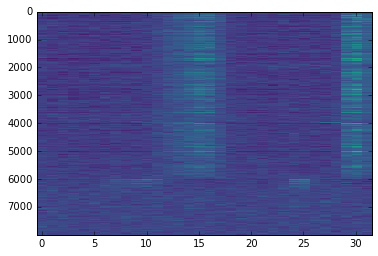

In [12]:
"""
Load Folded Spectra to do incoherent dynspec analysis

Need intermediate products to get noise estimates
"""

#fs = np.load('/media/drive2/b1957-GPs/newfold/FOLD1402643162.73-4s.npy')
#ic = np.load('/media/drive2/b1957-GPs/newfold/IC1402643162.73-4s.npy')

#n = fs/ic
#del fs, ic
n = np.load('/media/drive2/b1957-GPs/newfold/N1402643162.73-4s.npy')
n[np.isnan(n)] = 0

plt.imshow(n.sum(0) / n.sum(0).mean(-1, keepdims=True), cmap=cm.viridis, 
          aspect='auto', interpolation='nearest')

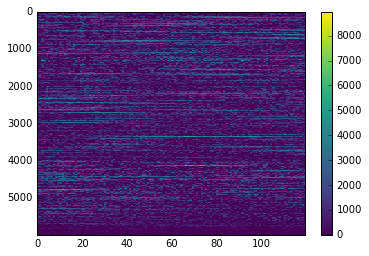

In [13]:
n_clean = n - np.concatenate((n[...,5:8], n[...,19:26]), axis=-1).mean(-1, keepdims=True)
dyn_signal = n_clean[14:,:6000, 29:32].mean(-1)
dyn_noise = n_clean[14:,:6000, 0:3].mean(-1)

#np.save('dyn_signal.npy', dyn_signal)
#np.save('dyn_noise.npy', dyn_noise)

plt.imshow(dyn_signal.T, interpolation='nearest', aspect='auto', cmap=cm.viridis, vmin=0)
plt.colorbar()

(-10, 486)

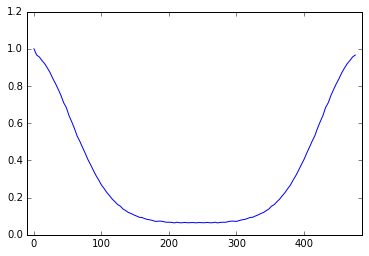

In [14]:
"""
Compute correlation timescale from dynspec

R  =       (p1-p1.mean) * (p2-p2.mean)
           ___________________________
     
     sqrt((sig1^2 - sig1n^2)(sig2^2 - sig2n^2))
     
"""
%matplotlib inline
chunk = 120

dyncorr = np.zeros(chunk)
tdyncorr = np.arange(0, chunk*4, 4)

for i in range(chunk):
    dyn1 = np.array(dyn_signal)
    dyn2 = np.roll(dyn_signal,-i,axis=0)
    
    dynbg1 = np.array(dyn_noise)
    dynbg2 = np.roll(dyn_noise,-i, axis=0)
    
    autoc = (dyn1 - np.mean(dyn1))  * (dyn2 - np.mean(dyn2))
    crossterms = dyn1*dynbg2 + dyn2*dynbg1
    bgcorr = dynbg1*dynbg2
    
    std1 = np.std(dyn1)**2.0 - np.mean(dynbg1**2.0)
    std2 = np.std(dyn2)**2.0 - np.mean(dynbg2**2.0)
    
    dyncorr[i] = np.mean( autoc / np.sqrt(std1 * std2)) - np.mean( bgcorr / np.sqrt(std1 * std2))
    
plt.plot(tdyncorr, dyncorr)
        
plt.xlim(-10,max(tdyncorr)+10)



((76800, 2), 6000, 1200)
43403.9203693


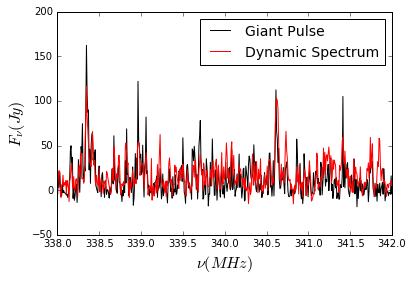

In [15]:
"""
Compute time difference between giant pulse and start of observation

Use this to find part in dynamic spectrum where giant pulse arrives
"""

#t_gp = Time('2014-06-13T06:01:21.91125', precision=5)
t_gp = Time('2014-06-13T07:00:02.13597', precision=5)

t0 = Time('2014-06-13T06:57:10.73000') + 14*4*u.s  # extra 4s

dT = t_gp.unix - t0.unix
Tbin = int(dT // 4)
GPdyn = dyn_signal[Tbin-2:Tbin+3,:6000].mean(0)

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

GP = np.concatenate((GPR[...,np.newaxis],GPL[...,np.newaxis]),axis=-1)
GP = rechanIm(GP, 6000)

freq = np.linspace(311.5,311.5+48,6001)[:-1]

pulse = (abs(GP[6])**2.0).sum(-1)
bg = (abs(GP[:5])**2.0).mean(0).sum(-1)
bgbin = (abs(GP[9])**2.0).sum(-1)

# Flux Calibration

GPspec = (pulse - bg) / np.mean(bg) * 12
GPdyn = GPdyn * GPspec.std() / GPdyn.std()

print(np.mean(bg))

%matplotlib inline

plt.plot(freq, GPspec, 'k', label='Giant Pulse')
plt.plot(freq, GPdyn, 'r', label='Dynamic Spectrum')

plt.plot()
plt.legend()
plt.xlabel(r'$\nu (MHz)$', fontsize=16)
plt.ylabel(r'$F_{\nu} (Jy)$', fontsize=16)
plt.legend(fontsize=14)

# Select subset for plotting
plt.xlim(338,342)

if figures:
    plt.savefig('{0}/SpecComp.pdf'.format(figdir), dpi=500)

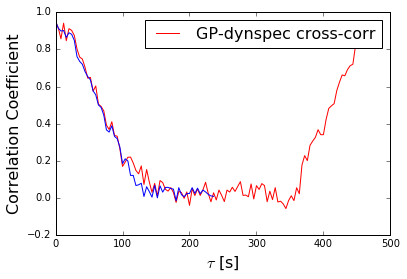

In [16]:
"""
Compute cross correlation between GP spectra and dynamic spectra

It should be maximal at zero lag if the pattern are the same
REQUIRES PREVIOUS STEPS ON DYNSPEC TO GET tdyncorr dyn_signal

"""

N = dyn_signal.shape[0]
ccarray = np.zeros(N)
dyn_comp = np.array(dyn_signal)
GP = pulse - bg

for i in range(-N//2, N//2):

    dyn1 = np.array(GP)
    dyn2 = np.array(dyn_signal[Tbin+i])
    
    dynbg1 = np.array(bgbin)
    dynbg2 = np.array(dyn_noise[Tbin+i])
    
    autoc = (dyn1 - np.mean(dyn1))  * (dyn2 - np.mean(dyn2))
    bgcorr = dynbg1*dynbg2
    
    std1 = np.std(dyn1)**2.0 - np.mean(dynbg1**2.0)
    std2 = np.std(dyn2)**2.0 - np.mean(dynbg2**2.0)
    
    ccarray[i] = np.mean( autoc / np.sqrt(std1 * std2)) - np.mean( bgcorr / np.sqrt(std1 * std2))   

h1 = ccarray[:len(ccarray)//2]
h2 = ccarray[len(ccarray)//2:]
cc_folded = (h1 + h2[::-1])/2

plt.plot(tdyncorr, ccarray, 'r', label='GP-dynspec cross-corr')
plt.plot(tdyncorr[:60], cc_folded)

plt.ylabel('Correlation Coefficient', fontsize=16)
plt.xlabel(r'$\tau$ [s]', fontsize=16)
plt.legend(fontsize=16)
if figures:
    plt.savefig('{0}DynCorr.pdf'.format(figdir))
    

In [17]:
def tcorr_loop(corr, n):
    noise = 0*np.random.normal(0, n, len(corr))
    cut = 1./np.e
    corr += noise
    
    for i in range(len(corr)):
        if corr[i]/corr[0] < cut:
            break
    return i*4

cc_cut = ccarray[N//2:]
yerror = 0.05

dasBoot = 100
timescale = np.zeros(dasBoot)

for j in range(dasBoot):
    timescale[j] = tcorr_loop(1.*cc_cut, yerror)
    
print("decorrelation timescale is %s s" % (np.mean(timescale)))

plt.errorbar(tgpcorr[N//2:], cc_folded, yerr = 0.05, marker='o', color='r', ecolor='r')

decorrelation timescale is 4.0 s


ERROR: NameError: name 'tgpcorr' is not defined [IPython.core.interactiveshell]


NameError: name 'tgpcorr' is not defined

In [18]:
"""
Set up pulse lists for de-scattering

Include both R and L pols
"""

b1957RGPs = np.loadtxt('/home/ramain/packages/scint_analysis/b1957_GPs/gp_RCP_SN12clean.txt', dtype='string')
b1957LGPs = np.loadtxt('/home/ramain/packages/scint_analysis/b1957_GPs/gp_LCP_SN12clean.txt', dtype='string')       
#b1957RGPs = np.loadtxt('/media/drive2/b1957-GPs/gp_RCP.txt', dtype='string')
#b1957LGPs = np.loadtxt('/media/drive2/b1957-GPs/gp_LCP.txt', dtype='string')

rT = Time(b1957RGPs[:,0], precision=5)
rSN = b1957RGPs[:,1].astype('float')
rphase = b1957RGPs[:,2].astype('float')

# Pulses used as Green's function measurements
SNcut = 40
rT = rT[rSN > SNcut]
rphase = rphase[rSN > SNcut]
rSN = rSN[rSN > SNcut]

rphase = rphase[abs(rT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
rSN = rSN[abs(rT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
rT = rT[abs(rT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

rSN = rSN[abs(rphase-0.8) < 0.1 ]
rT = rT[abs(rphase-0.8) < 0.1 ]
rphase = rphase[abs(rphase-0.8) < 0.1 ]


lT = Time(b1957LGPs[:,0], precision=5)
lSN = b1957LGPs[:,1].astype('float')
lphase = b1957LGPs[:,2].astype('float')

# Pulses used as Green's function measurements
lT = lT[lSN > SNcut]
lphase = lphase[lSN > SNcut]
lSN = lSN[lSN > SNcut]

lphase = lphase[abs(lT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
lSN = lSN[abs(lT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
lT = lT[abs(lT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

lSN = lSN[abs(lphase-0.8) < 0.1 ]
lT = lT[abs(lphase-0.8) < 0.1 ]
lphase = lphase[abs(lphase-0.8) < 0.1 ]

Tphase = np.concatenate((rT,lT))
SNphase = np.concatenate((rSN,lSN))
pol = []
for i in range(len(rT)):
    pol.append('R')
for i in range(len(lT)):
    pol.append('L')

    
# Pulses for de-scattering

rT = Time(b1957RGPs[:,0], precision=5)
rSN = b1957RGPs[:,1].astype('float')
rphase = b1957RGPs[:,2].astype('float')

lT = Time(b1957LGPs[:,0], precision=5)
lSN = b1957LGPs[:,1].astype('float')
lphase = b1957LGPs[:,2].astype('float')

SNcut = 12
rT = rT[rSN > SNcut]
rphase = rphase[rSN > SNcut]
rSN = rSN[rSN > SNcut]

rSN = rSN[abs(rphase-0.8) < 0.1 ]
rT = rT[abs(rphase-0.8) < 0.1 ]
rphase = rphase[abs(rphase-0.8) < 0.1 ]

lT = lT[lSN > SNcut]
lphase = lphase[lSN > SNcut]
lSN = lSN[lSN > SNcut]

lSN = lSN[abs(lphase-0.8) < 0.1 ]
lT = lT[abs(lphase-0.8) < 0.1 ]
lphase = lphase[abs(lphase-0.8) < 0.1 ]

In [19]:
print(pol)
print(Tphase)

z1 = np.load('SNcorrectionPol.npy')
z2 = np.load('SNnoisePol.npy')
SNcorrectionPol = np.poly1d(z1)
SNnoisePol = np.poly1d(z2)

['R', 'R', 'R', 'R', 'R', 'R', 'L', 'L', 'L']
[<Time object: scale='utc' format='isot' value=2014-06-13T06:01:21.91125>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:19:34.04710>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:49:56.52016>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:00:02.13597>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:45:04.81882>
 <Time object: scale='utc' format='isot' value=2014-06-16T07:09:37.37528>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:09:27.16265>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:45:04.81882>
 <Time object: scale='utc' format='isot' value=2014-06-14T07:05:58.73615>]


pulse 2014-06-13T06:01:21.91125 de-convolving 9 pulses within 360 seconds


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


pulse 2014-06-13T06:19:34.04710 de-convolving 10 pulses within 360 seconds
pulse 2014-06-13T06:49:56.52016 de-convolving 8 pulses within 360 seconds
pulse 2014-06-13T07:00:02.13597 de-convolving 7 pulses within 360 seconds
pulse 2014-06-13T07:45:04.81882 de-convolving 7 pulses within 360 seconds
pulse 2014-06-16T07:09:37.37528 de-convolving 5 pulses within 360 seconds
pulse 2014-06-13T07:09:27.16265 de-convolving 6 pulses within 360 seconds
pulse 2014-06-13T07:45:04.81882 de-convolving 8 pulses within 360 seconds
pulse 2014-06-14T07:05:58.73615 de-convolving 7 pulses within 360 seconds


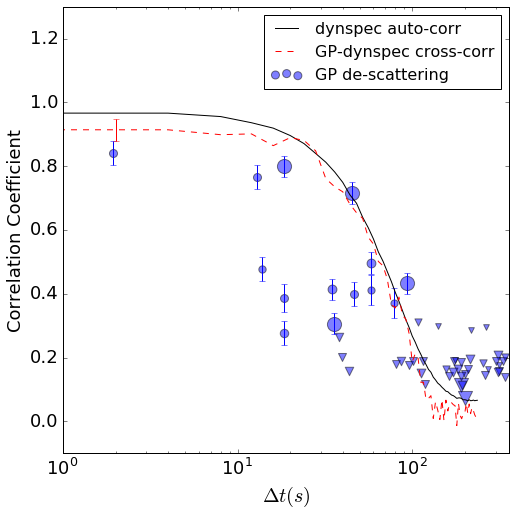

In [51]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 
USING VISIBILITY METHOD

FIGURE in Paper
"""

%matplotlib inline

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles
timespan = 360 # time to correlate each GP with

cratio = pchan // cchan

plt.figure(figsize=(8,8))
#fig, ax1 = plt.subplots()

for j in range(len(Tphase)):
#for j in range(3):
    td = []
    Tcal = Tphase[j]

    if pol[j]=='R':
        pb_dT = abs(rT.unix - Tcal.unix)
        T2 = rT[pb_dT < timespan]
        SN2 = rSN[pb_dT < timespan]
    if pol[j]=='L':
        pb_dT = abs(lT.unix - Tcal.unix)
        T2 = lT[pb_dT < timespan]
        SN2 = lSN[pb_dT < timespan]


    print("pulse %s de-convolving %s pulses within %s seconds" % (Tcal, len(T2), timespan))
    npulses = len(T2)
    pratio = np.zeros(npulses)
    plimit = np.zeros(npulses)

    p1 = np.load('/media/drive2/b1957-GPs/%sGPs/GP%s.npy' % (pol[j],Tcal.isot))
    p1 = np.concatenate((p1,nyq_pad), axis=1)
    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    # Get SN for correction:
    ts1SN = dechannelize(p1)
    SN1 = np.std(ts1SN[76600:76600+1024*3])**2 / np.std(ts1SN[:1024*3])**2 - 1
    SNcorr = SNcorrectionPol(SN1)
    ###
    
    for i in range(npulses):
        p2 = np.load('/media/drive2/b1957-GPs/%sGPs/GP%s.npy' % (pol[j],T2[i]))
        p2 = np.concatenate((p2,nyq_pad), axis=1)

        # Get SN for errorbar:
        ts2SN = dechannelize(p2)
        SN2 = np.std(ts2SN[76600:76600+1024*3])**2 / np.std(ts2SN[:1024*3])**2 - 1
        ###
        
        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), cratio*(518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
            abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

        pauto = np.sqrt(p11max*p22max)

        # Flag upper limits
        powtemp = (abs(p12pcorr)**2.0).sum(1)
        peakloc = np.argmax(powtemp[cratio*511:cratio*577])
        detection = powtemp[cratio*511:cratio*577][peakloc]
        level = np.median( np.delete(powtemp[cratio*511:cratio*577], peakloc) )
        sig = np.std( np.delete(powtemp[cratio*511:cratio*577], peakloc) )
        
        if detection < level+5*sig:
            plimit[i] = (pcross / pauto)
            pratio[i] = -6
        else:
            pratio[i] = (pcross / pauto)
            plimit[i] = -6

        td.append(abs(Tcal.unix - Time(T2[i]).unix))

    pr1 = 1*pratio
    pr2 = 1.*plimit
    td1 = 1.*np.array(td)

    #SNcorr = 1. * np.sqrt(1+(SNphase[j]/np.sqrt(2*fchan))**-2.0)
    if j ==0:
        plt.scatter(td1, pr1/SNcorr, s=SN1*50, alpha=0.5, label='GP de-scattering')
        plt.errorbar(td1, pr1/SNcorr, yerr=SNnoisePol(SN2), ecolor='b', fmt='none')
        plt.scatter(td1, pr2/SNcorr, s=SN1*50, alpha=0.5, marker='v')
    else:
        plt.scatter(td1, pr1/SNcorr, s=SN1*50, alpha=0.5)
        plt.errorbar(td1, pr1/SNcorr, yerr=SNnoisePol(SN2), ecolor='b', fmt='none')
        plt.scatter(td1, pr2/SNcorr, s=SN1*50, alpha=0.5, marker='v')

plt.plot(tdyncorr[:60], dyncorr[:60], 'k', label='dynspec auto-corr')
plt.plot(tdyncorr[:60], cc_folded, 'r--', label='GP-dynspec cross-corr')

plt.xlim(1,360)
plt.ylim(-0.1,1.3)

plt.legend(fontsize=16)
plt.xscale('log')
plt.xlabel(r'$\Delta t (s)$', fontsize=20)
plt.ylabel('Correlation Coefficient', fontsize=18)
plt.errorbar(2, cc_folded[1],yerr=0.034, color='r', ecolor='r')


plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

#ax1.set_xlabel(r'$\Delta t (s)$', fontsize=16)
#ax1.set_ylabel('Correlation Coefficient', fontsize=14)
#ax2 = ax1.twinx()
#ax2.set_ylim(-0.1,1.3)
#ax2.set_ylabel('De-Scattered Power Ratio', fontsize=14)

#ax1.legend()
#ax1.errorbar(2, cc_folded[1],yerr=0.034, color='r', ecolor='r')
#ax1.errorbar(2, 0.86,yerr=dynerr, color='k', ecolor='k')

if figures:
    plt.savefig('{0}/AllCorr.pdf'.format(figdir), dpi=500)

pulse 2014-06-13T06:01:21.91125 de-convolving 15 pulses within 600 seconds


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


pulse 2014-06-13T06:19:34.04710 de-convolving 17 pulses within 600 seconds
pulse 2014-06-13T06:49:56.52016 de-convolving 15 pulses within 600 seconds
pulse 2014-06-13T07:00:02.13597 de-convolving 10 pulses within 600 seconds
pulse 2014-06-13T07:45:04.81882 de-convolving 14 pulses within 600 seconds
pulse 2014-06-16T07:09:37.37528 de-convolving 7 pulses within 600 seconds
pulse 2014-06-13T07:09:27.16265 de-convolving 11 pulses within 600 seconds
pulse 2014-06-13T07:45:04.81882 de-convolving 19 pulses within 600 seconds
pulse 2014-06-14T07:05:58.73615 de-convolving 7 pulses within 600 seconds
0.40562030792


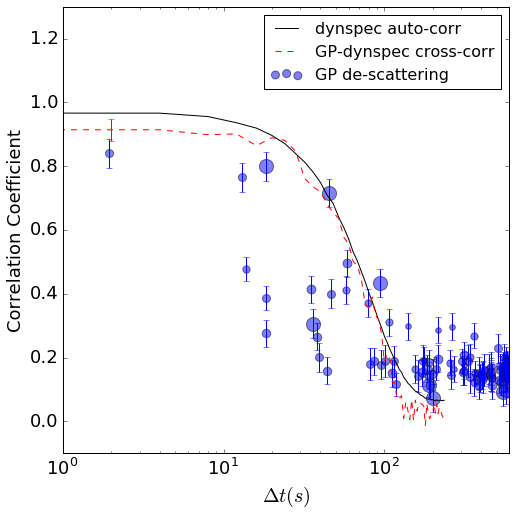

In [20]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 
Upper limits shown as such

FIGURE 5 in Paper
"""

%matplotlib inline

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles
timespan = 200 # time to correlate each GP with

cratio = pchan // cchan

plt.figure(figsize=(8,8))
#fig, ax1 = plt.subplots()

for j in range(len(Tphase)):
#for j in range(3):
    td = []
    Tcal = Tphase[j]

    if pol[j]=='R':
        pb_dT = abs(rT.unix - Tcal.unix)
        T2 = rT[pb_dT < timespan]
        SN2 = rSN[pb_dT < timespan]
    if pol[j]=='L':
        pb_dT = abs(lT.unix - Tcal.unix)
        T2 = lT[pb_dT < timespan]
        SN2 = lSN[pb_dT < timespan]


    print("pulse %s de-convolving %s pulses within %s seconds" % (Tcal, len(T2), timespan))
    npulses = len(T2)
    pratio = np.zeros(npulses)
    pratio2 = np.zeros(npulses)

    p1 = np.load('/media/drive2/b1957-GPs/%sGPs/GP%s.npy' % (pol[j],Tcal.isot))
    p1 = np.concatenate((p1,nyq_pad), axis=1)
    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    # Get SN for correction:
    ts1SN = dechannelize(p1)
    SN1 = np.std(ts1SN[76600:76600+1024*3])**2 / np.std(ts1SN[:1024*3])**2 - 1
    SNcorr = SNcorrectionPol(SN1)
    ###
    
    for i in range(npulses):
        p2 = np.load('/media/drive2/b1957-GPs/%sGPs/GP%s.npy' % (pol[j],T2[i]))
        p2 = np.concatenate((p2,nyq_pad), axis=1)

        # Get SN for errorbar:
        ts2SN = dechannelize(p2)
        SN2 = np.std(ts2SN[76600:76600+1024*3])**2 / np.std(ts2SN[:1024*3])**2 - 1
        ###
        
        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), cratio*(518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
            abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

        pauto = np.sqrt(p11max*p22max)

        pratio[i] = (pcross / pauto)

        td.append(abs(Tcal.unix - Time(T2[i]).unix))

    pr1 = 1*pratio
    td1 = 1.*np.array(td)

    #SNcorr = 1. * np.sqrt(1+(SNphase[j]/np.sqrt(2*fchan))**-2.0)
    if j ==0:
        plt.scatter(td1, pr1/SNcorr, s=SN1*50, alpha=0.5, label='GP de-scattering')
        plt.errorbar(td1, pr1/SNcorr, yerr=SNnoisePol(SN2), ecolor='b', fmt='none')
    else:
        plt.scatter(td1, pr1/SNcorr, s=SN1*50, alpha=0.5)
        plt.errorbar(td1, pr1/SNcorr, yerr=SNnoisePol(SN2), ecolor='b', fmt='none')
        
print(SNcorr)
plt.plot(tdyncorr[:60], dyncorr[:60], 'k', label='dynspec auto-corr')
plt.plot(tdyncorr[:60], cc_folded, 'r--', label='GP-dynspec cross-corr')

plt.xlim(1,600)
plt.ylim(-0.1,1.3)

plt.legend(fontsize=16)
plt.xscale('log')
plt.xlabel(r'$\Delta t (s)$', fontsize=20)
plt.ylabel('Correlation Coefficient', fontsize=18)
plt.errorbar(2, cc_folded[1],yerr=0.034, color='r', ecolor='r')


plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

#ax1.set_xlabel(r'$\Delta t (s)$', fontsize=16)
#ax1.set_ylabel('Correlation Coefficient', fontsize=14)
#ax2 = ax1.twinx()
#ax2.set_ylim(-0.1,1.3)
#ax2.set_ylabel('De-Scattered Power Ratio', fontsize=14)

#ax1.legend()
#ax1.errorbar(2, cc_folded[1],yerr=0.034, color='r', ecolor='r')
#ax1.errorbar(2, 0.86,yerr=dynerr, color='k', ecolor='k')

if figures:
    plt.savefig('{0}/AllCorr.pdf'.format(figdir), dpi=500)

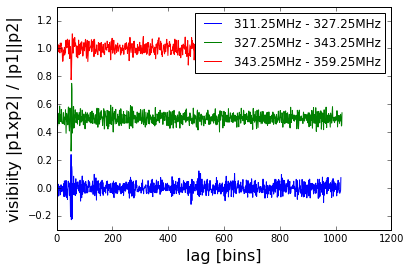

In [12]:
"""
Work with our best pulse pair

Look for voltage correlation a la I-Sheng's method
"""
%matplotlib inline

IF1 = slice(0,256)
IF2 = slice(256,513)
IF3 = slice(511,768)
IFfreq = ([311.25,327.25,343.25,359.25])

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:21.91125'))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:23.83364'))

#p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))
#p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:20.48211'))

p1 = np.concatenate((p1,nyq_pad), axis=-1)
p2 = np.concatenate((p2,nyq_pad), axis=-1)

i = 0
for IF in ([IF1,IF2,IF3]):
    p1temp = dechannelize(p1[49:51,IF])
    p2temp = dechannelize(p2[49:51,IF])
    
    p12pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p2temp))))
    p11pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p1temp))))
    p22pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))

    corr_norm = np.sqrt(max(abs(p11pcorr))*max(abs(p22pcorr)))

    time_p = np.linspace(0,len(p12pcorr),len(p12pcorr)) * 31.25/3
        
    plt.plot(p12pcorr/corr_norm + i*0.5, label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))
    
    i+=1

roll = np.argmax(np.abs(p12pcorr))
    
plt.xlabel('lag [bins]', fontsize=16)
plt.ylabel('visibiity |p1xp2| / |p1||p2|', fontsize=16)

#plt.xlim(0,100)
plt.ylim(-0.3,1.3)

plt.legend()


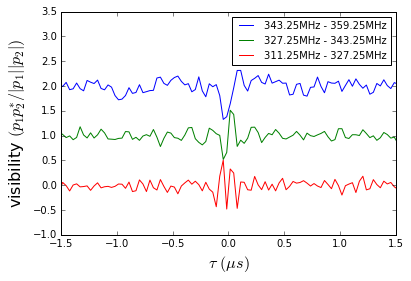

In [13]:
"""
Using above plot, align pulses to ~0 lag, re-correlate, and shift to plot properly

FIGURE IN PAPER
"""

i = 2
for IF in ([IF3,IF2,IF1]):
    p1temp = dechannelize(p1[49:51,IF])
    p2temp = dechannelize(p2[49:51,IF])
    
    p2temp = np.roll(p2temp, roll+2 )
    
    p12pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p2temp))))
    p11pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p1temp))))
    p22pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))

    # Compute noise autocorrelations
    p1temp = dechannelize(p1[39:41,IF])
    p2temp = dechannelize(p2[39:41,IF])

    p11bg = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p1temp))))
    p22bg = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))
    
    corr_norm = np.sqrt( (max(abs(p11pcorr))-max(abs(p11bg)))
                        * (max(abs(p22pcorr))-max(abs(p22bg)))  )
    
    time_p = np.linspace(-len(p12pcorr)//2,len(p12pcorr)//2,len(p12pcorr)) * 31.25 / 1000.

    p12pcorr_shifted = np.roll(p12pcorr, len(p12pcorr)//2)
    
    if i == 0:
        plt.plot(time_p, p12pcorr_shifted/corr_norm + i, 'r', 
                 label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))
    if i == 1:
        plt.plot(time_p, p12pcorr_shifted/corr_norm + i, 'g', 
                 label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))
    if i == 2:
        plt.plot(time_p, p12pcorr_shifted/corr_norm + i, 'b', 
                 label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))   
    i-=1
    
plt.xlabel(r'$\tau \ (\mu s)$', fontsize=16)
plt.ylabel(r'visibility $(p_{1} p_{2}^{*} / |p_{1}||p_{2}|)$', fontsize=16)

plt.xlim(-1.5,1.5)
plt.ylim(-1,3.5)

plt.xticks(np.arange(-1.5, 1.5+0.01, 0.5))

plt.legend(fontsize=10)

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/Visibility.pdf')

In [14]:
"""
Proper Motion 
"""

pmRA=-16.0*np.cos(20*u.deg)*u.arcsec / u.year
pmDec=-25.8*u.arcsec / u.year

PM =  np.sqrt(pmRA**2.0+pmDec**2.0)*np.pi/(3600*180*u.arcsec) * 2*u.kpc

print PM

0.00028954275932 kpc / yr


In [15]:
'''
Mosaic of De-scattered pulses
'''

import matplotlib.lines as mlines

#t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
#t_p = Time('2014-06-13T06:01:23.83364', precision=5)

nyq_pad = np.zeros((100,1))
Tsys = 12 # (120K, gain = 10K / Jansky)

def corr_12_plot(t1, t2, roll):

    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t1.isot))
    p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t2.isot))

    p1 = np.concatenate((p1,nyq_pad), axis=-1)
    p2 = np.concatenate((p2,nyq_pad), axis=-1)

    p1temp = rechannelize(p1, 3*16)
    p2temp = rechannelize(p2, 3*16)

    p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
    p2temp = np.roll(p2temp, 1032+roll-np.argmax(abs(p2temp).sum(-1)), axis=0)

    corr = correlate_power(p2temp, p1temp, 4*3, 1024*3)
    p1prof = rechannelize(p1temp, 4*3)
    p2prof = rechannelize(p2temp, 4*3)

    # Turn into Flux units using gain = 10K / Jy, Tsys = 120K

    p1flux = (abs(p1prof)**2.0).sum(-1)
    p1flux = (p1flux /p1flux[:500].mean() - 1) * 12
    p2flux = (abs(p2prof)**2.0).sum(-1)
    p2flux = (p2flux /p2flux[:500].mean() - 1) * 12
    c1flux = (abs(corr)**2.0).sum(-1)
    c1flux = (c1flux /c1flux[:500].mean() - 1) * 12

    # Fiddly Plotting Commands

    t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

    #plt.plot(t_axis-224, p1flux)
    plt.figure(figsize=(20,5))
    plt.plot(t_axis-224, p2flux -50, 'r', linewidth='2')
    plt.plot(t_axis-224, c1flux, 'k', linewidth='2')
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)

    plt.ylim(-100,350)
    plt.xlim(-20,100)
    #plt.xlabel(r'$t\ (\mu s)$', fontsize=16)
    plt.ylabel(r'$F_{\nu}\ (Jy)$', fontsize=30)

In [16]:
t1 = Time('2014-06-13T06:01:21.91125', precision=5)

timespan = 200
pb_dT = abs(rT.unix - t1.unix)
T2 = rT[pb_dT < timespan]

SN2 = rSN[pb_dT < timespan]
rolling = [0,5,-5,5,0,5, 7, 10, 3]


for i in range(len(T2)):
    corr_12_plot(t1, T2[i], rolling[i])
    dT = t1.unix - T2[i].unix
    plt.text(80,250, r'$\Delta t = %s\ s$' % (np.round(dT,1)), fontsize=30)
    
    if i == len(T2)-1:
        plt.xlabel(r'$t\ (\mu s)$', fontsize=30)
    else:
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])

    plt.tight_layout()
    plt.yticks(np.arange(-100, 400, 100))
    #plt.savefig('/home/ramain/packages/b1957GiantPulses/GP%s.pdf' 
    plt.savefig('/home/ramain/Desktop/GP%s.pdf' 
                % ( np.round(dT,0) ), dpi=500)
    plt.clf()

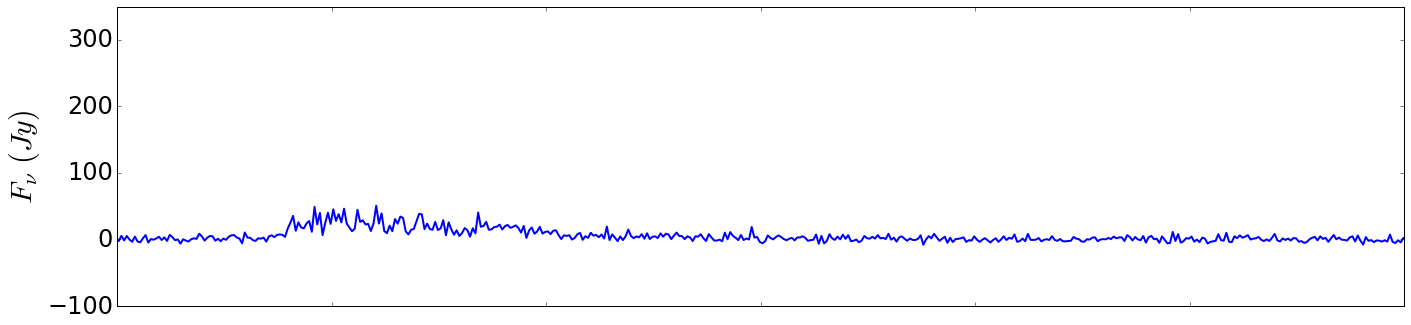

In [17]:
    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t1.isot))
    p1 = np.concatenate((p1,nyq_pad), axis=-1)
    p1temp = rechannelize(p1, 3*16)
    p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
    p1prof = rechannelize(p1temp, 4*3)

    # Turn into Flux units using gain = 10K / Jy, Tsys = 120K
    p1flux = (abs(p1prof)**2.0).sum(-1)
    p1flux = (p1flux /p1flux[:500].mean() - 1) * 12

    # Fiddly Plotting Commands
    t_axis = 31.25 * np.linspace(-p1prof.shape[0]/2, p1prof.shape[0]/2, p1prof.shape[0]) * 4 * 2 / 1000

    #plt.plot(t_axis-224, p1flux)
    plt.figure(figsize=(20,5))
    plt.plot(t_axis-224, p1flux, 'b', linewidth='2')

    plt.ylim(-100,350)
    plt.xlim(-20,100)
    #plt.xlabel(r'$t\ (\mu s)$', fontsize=16)
    plt.ylabel(r'$F_{\nu}\ (Jy)$', fontsize=30)
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.yticks(np.arange(-100, 400, 100))
    
    frame1 = plt.gca()
    #frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.xaxis.set_ticklabels([])
    
    #plt.savefig('/home/ramain/packages/b1957GiantPulses/GPbrightest.pdf' 
    plt.savefig('/home/ramain/Desktop/GPbrightest.pdf'
                % ( np.round(dT,1) ), dpi=500)

ERROR: TypeError: scalar 'Time' object is not subscriptable. [astropy.time.core]


TypeError: scalar 'Time' object is not subscriptable.

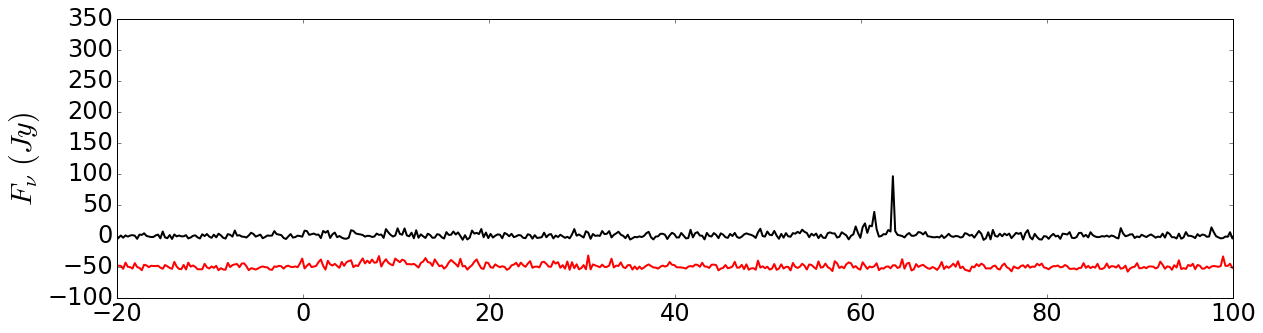

In [30]:
t1 = Time('2014-06-13T07:00:02.13597', precision=5)
tL = Time('2014-06-13T07:00:11.44245', precision=5)
t1 = Time('2014-06-13T06:01:21.91125', precision=5)

'''
2014-06-13T07:00:02.13602 8.178191185 0.826843261719 
2014-06-13T07:00:08.22778 10.106760025 0.798461914062 
2014-06-13T07:00:08.89963 6.24361848831 0.792297363281 
2014-06-13T07:00:10.97149 6.56337451935 0.791442871094 
2014-06-13T07:00:10.97150 9.43688106537 0.802001953125 
2014-06-13T07:00:11.44245 8.67203521729 0.797973632812 
2014-06-13T07:00:20.48210 11.7461280823 0.790771484375 
2014-06-13T07:00:20.48211 16.357793808 0.800231933594 
2014-06-13T07:00:36.57738 8.69841384888 0.424926757812 
2014-06-13T07:00:38.43443 6.77617883682 0.787902832031 
2014-06-13T07:00:40.29574 6.24249505997 0.797973632812 
2014-06-13T07:00:45.67710 6.20962524414 0.79638671875 
2014-06-13T07:00:51.13403 6.23602962494 0.809692382812 
2014-06-13T07:00:51.39440 6.36012268066 0.796569824219 
2014-06-13T07:00:51.59853 7.82040071487 0.794616699219 
2014-06-13T07:00:51.59854 6.26052236557 0.804077148438 
2014-06-13T07:00:58.73130 9.53353595734 0.426513671875 
'''


t2 = Time('2014-06-13T07:00:20.48211', precision=5)
t3 = Time('2014-06-13T06:59:26.29880', precision=5)
t4 = Time('2014-06-13T06:59:17.14341', precision=5)
t5 = Time('2014-06-13T07:01:35.97227', precision=5)
t6 = Time('2014-06-13T07:03:11.21014', precision=5)

corr_12_plot(t1, tL, 0)

plt.savefig('/home/ramain/Desktop/%s_%s.png' % (tL[i], SN[i]))

In [18]:
dyne = dyn_day3.reshape(-1,1000,8).mean(-1)
dyne = dyne[:,:750]

%matplotlib qt
plt.imshow(dyn_day3.T, aspect='auto', interpolation='nearest', cmap=cm.Greys,
           vmin=-2000, vmax=3000, extent=[0,dynb.shape[0]/20, 359.25, 311.25])

In [66]:
%matplotlib qt

t1 = Time('2014-06-13T06:01:21.91125', precision=5)
t2 = Time('2014-06-13T06:01:23.83364', precision=5)
#tL = Time('2014-06-13T07:00:11.44245', precision=5)
#t1 = Time('2014-06-13T07:00:02.13597', precision=5)

roll = 2

#corr_12_plot(t1, tL, 2)

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t1.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t2.isot))

p1 = np.concatenate((p1,nyq_pad), axis=-1)
p2 = np.concatenate((p2,nyq_pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)

p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2temp, 1032+roll-np.argmax(abs(p2temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
corrnorm = correlate_power(p2temp, p2temp, 4*3, 512*3)
p1prof = rechannelize(p1temp, 4*3)
p2prof = rechannelize(p2temp, 4*3)

# Turn into Flux units using gain = 10K / Jy, Tsys = 120K

p1flux = (abs(p1prof)**2.0).sum(-1)
p1flux = (p1flux /p1flux[:500].mean() - 1) * 12
p2flux = (abs(p2prof)**2.0).sum(-1)
p2flux = (p2flux /p2flux[:500].mean() - 1) * 12
c1flux = (abs(corr)**2.0).sum(-1)
#c1flux = (c1flux /c1flux[:500].mean() - 1) * 12

c2flux = (abs(corrnorm)**2.0).sum(-1)
#c2flux = (c1flux /c1flux[:500].mean() - 1) * 12


# Fiddly Plotting Commands

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

#plt.plot(t_axis-224, p1flux)
plt.figure(figsize=(20,5))
plt.plot(t_axis-224, c2flux, 'r', linewidth='2')
plt.plot(t_axis-224, c1flux, 'k', linewidth='2')
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

#plt.xlim(-20,100)
#plt.xlabel(r'$t\ (\mu s)$', fontsize=16)
plt.ylabel(r'$F_{\nu}\ (Jy)$', fontsize=30)




In [16]:
%matplotlib inline
p1temp = rechannelize(p1, 3*512)

PowerTemp = (np.abs(p1temp)**2.0)
p1SN = (PowerTemp - np.median(PowerTemp, axis=0, keepdims=True)) / np.std(PowerTemp[:20], axis=0, keepdims=True)



correction = np.sqrt(1+(40/np.sqrt(3*512))**-2.0)

#plt.plot(abs(p1temp[25])**2.0)

#correction = np.sqrt(1+(p1SN[25])**-2.0)[np.newaxis,:]

#corr_testflux = (abs(corr)**2.0 * correction).sum(1)

p1fine = rechannelize(p1, 3*512)
p2fine = rechannelize(p2, 3*512)
p12_phased = (p1fine) * (abs(p2fine) / p2fine)
corr = rechannelize(p12_phased, 3*16)

c1flux = (abs(corr)**2.0).sum(-1)
#c1flux = (c1flux /c1flux[:500].mean() - 1) * 12

c2flux = (abs(corrnorm)**2.0).sum(-1)
#c2flux = (c1flux /c1flux[:500].mean() - 1) * 12

plt.figure(figsize=(20,5))
plt.plot(t_axis-224, c2flux, 'r', linewidth='2')
plt.plot(t_axis-224, c1flux, 'k', linewidth='2')
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

#plt.xlim(-20,100)
#plt.xlabel(r'$t\ (\mu s)$', fontsize=16)
plt.ylabel(r'$F_{\nu}\ (Jy)$', fontsize=30)


ERROR: NameError: name 'p1' is not defined [IPython.core.interactiveshell]


NameError: name 'p1' is not defined

In [68]:
a = (145000 - 111000)
b = 10000.

a = (88000 - 58000)
b = 11000.

print b / a * 1.4

0.513333333333


0.0283112


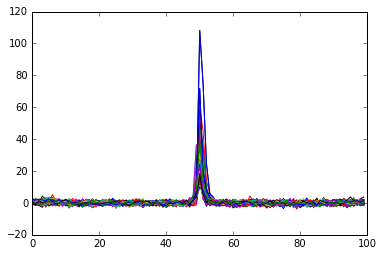

In [6]:
""" Getting to Fig 1A Rough method to get S/N sigma to flux conversion """

ratioarr = []

for time in rT[:100]:
    try:
        pR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (time))
        pL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (time))
   
        I = np.abs(pR)**2.0 + np.abs(pL)**2.0
        I = I.sum(-1)

        SN = (I - I[:45].mean(0)) / I[:45].std(0)

        ratio = I[:45].std(0) / I[:45].mean(0)
        ratioarr.append(ratio)
    except:
        a=1
    plt.plot(SN)
    
sig_conversion = np.mean(np.array(ratioarr))
print sig_conversion